In [4]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (10,8)

from constant import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


mean:     -70.3			std:      4.62


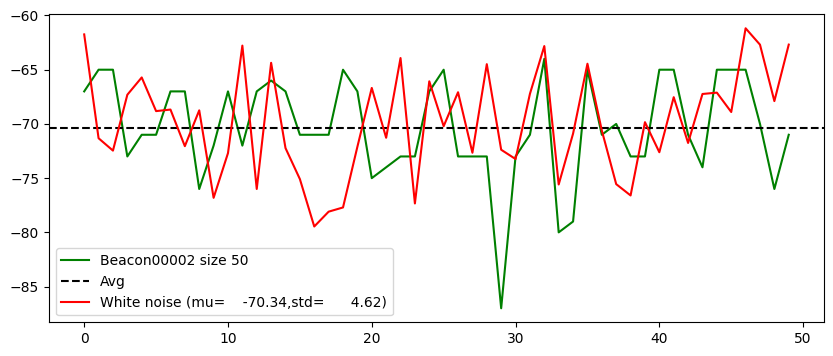

mean:     -69.8			std:      4.53


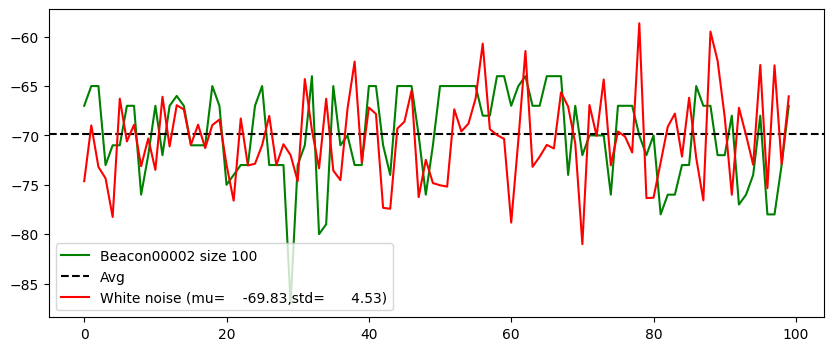

mean:     -70.4			std:      4.35


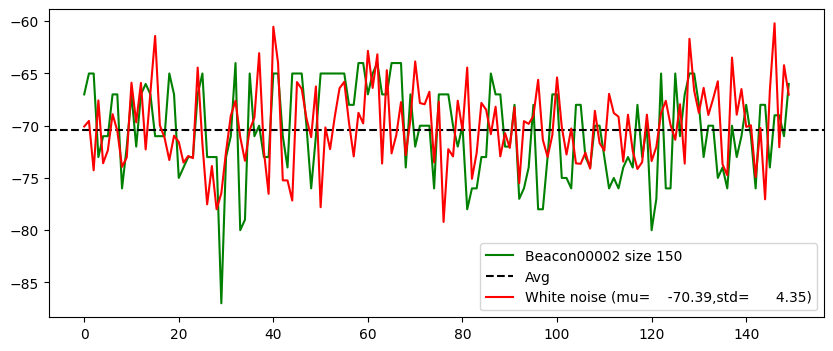

mean:     -70.6			std:      4.57


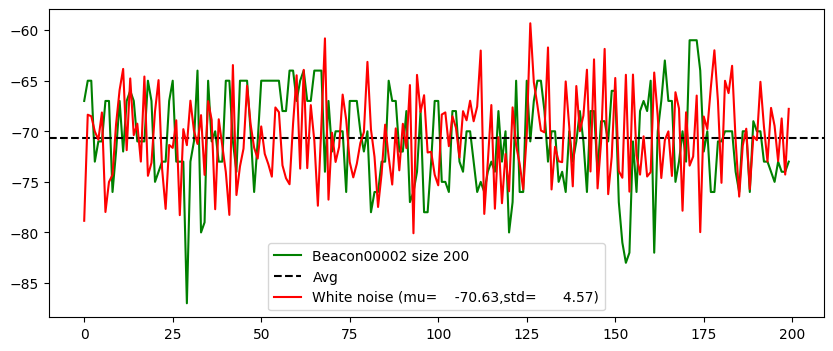

mean:     -70.6			std:      4.29


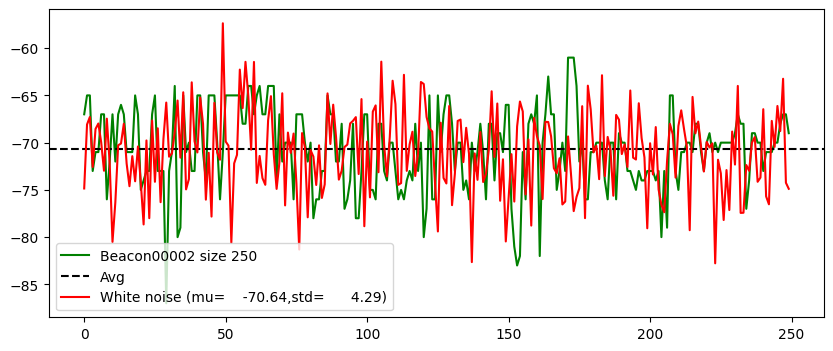

mean:     -70.4			std:      4.09


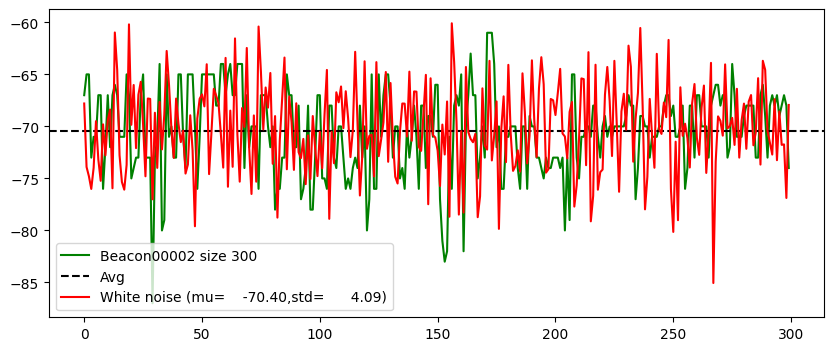

mean:     -70.4			std:      3.92


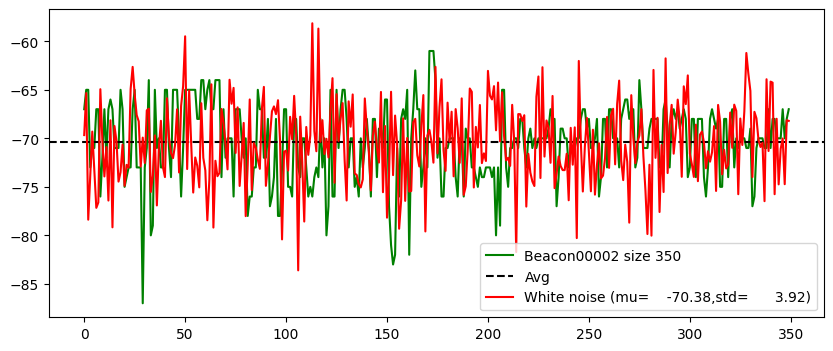

mean:     -70.3			std:       3.9


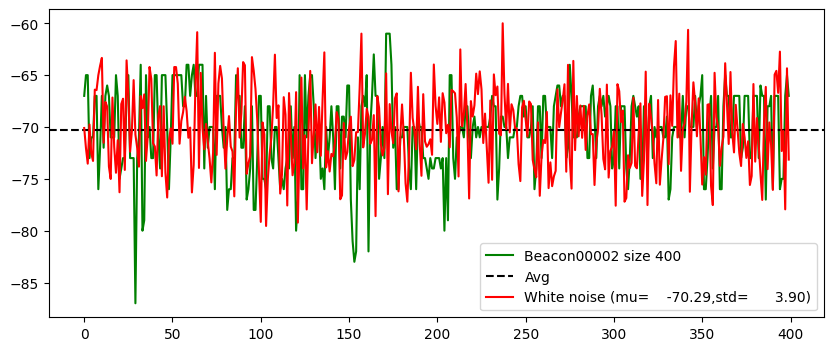

mean:     -70.1			std:      3.85


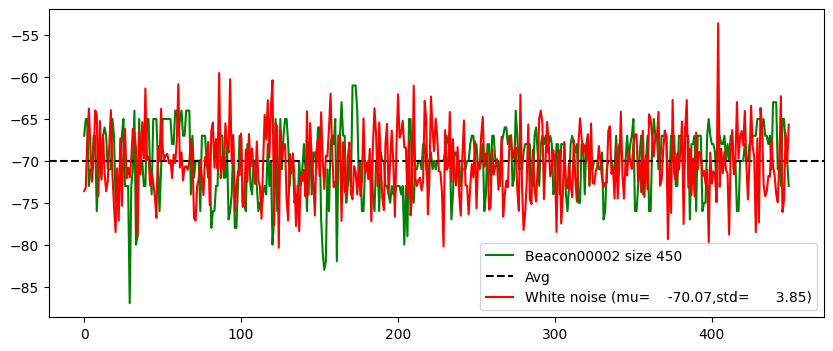

mean:     -70.0			std:      3.84


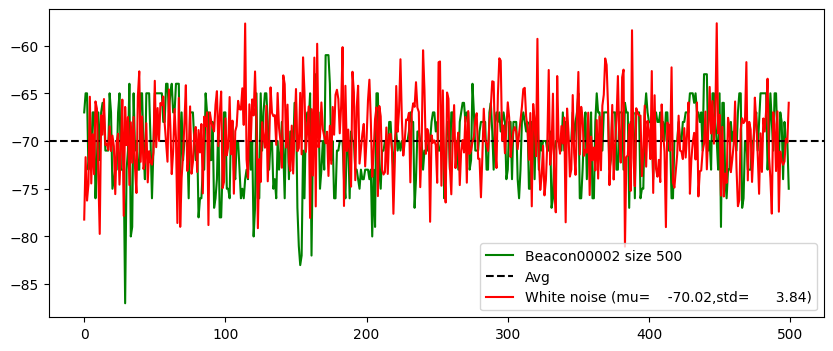

In [5]:
# BEACONS = np.array(['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006'])
BEACONS = np.array(['Beacon00002'])
from filterpy.common import Q_discrete_white_noise

beacon = 'Beacon00002'
rssi = np.array(RSSI500[beacon])
rssi_filter_js = RSSI500

def plot_white_noise(data, label=beacon):
    rssi_beacon = data
    print(f'mean:{rssi_beacon.mean():10.3}\t\t\tstd:{rssi_beacon.std():10.3}')

    plt.rcParams["figure.figsize"] = (10,4)
    plt.plot(list(range(rssi_beacon.size)), rssi_beacon, c='green', label=f'{label} size {rssi_beacon.size}')
    # plot mean line
    plt.axhline(y=np.nanmean(rssi_beacon), label='Avg', c='k', linestyle='--')

    # white noise
    mean = rssi_beacon.mean()
    std = rssi_beacon.std()
    num_samples = rssi_beacon.size
    samples = np.random.normal(mean, std, size=num_samples)
    plt.plot(samples,'r-', label=f'White noise (mu={mean:10.2f},std={std:10.2f})')
    plt.legend()
    plt.show()

step = 50
for i in range(step, rssi.size, step):
    rssi_beacon = rssi[:i]
    plot_white_noise(rssi_beacon)


# APPLY KALMAN FILTER

	x0	v0	var0		z		x	v	var
     -60.0       0.0   100.040	     -67.0	     -66.0     -0.02 13.793866
     -66.0      -0.0    13.845	     -65.0	     -65.6    -0.008  7.422475
     -65.6      -0.0     7.513	     -65.0	     -65.4     0.007  5.112289
     -65.4       0.0     5.243	     -73.0	     -67.3      -0.3  3.948779
     -67.3      -0.3     4.119	     -71.0	     -68.0      -0.5  3.275782
     -68.1      -0.5     3.485	     -71.0	     -68.6      -0.7  2.861692
     -68.7      -0.7     3.108	     -67.0	     -68.4      -0.6  2.602324
     -68.5      -0.6     2.882	     -67.0	     -68.2      -0.4  2.442362
     -68.3      -0.4     2.752	     -76.0	     -69.4    -1e+00  2.348461
     -69.5      -1.1     2.684	     -72.0	     -69.9    -1e+00  2.298486
     -70.0      -1.4     2.655	     -67.0	     -69.6    -1e+00  2.276774
     -69.7      -1.1     2.648	     -72.0	     -70.0    -1e+00  2.271905
     -70.2      -1.3     2.653	     -67.0	     -69.7    -1e+00  2.275560
     -69.8      -1.0     2.

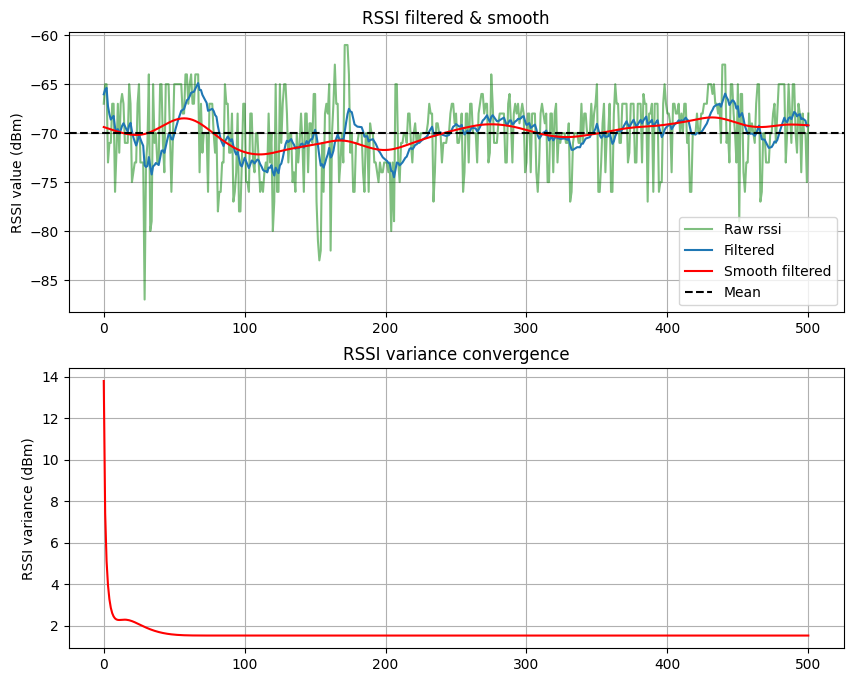

raw rssi {'mean': -70.01996007984032, 'std': 3.8333030631109617}
filtered {'mean': -70.02708991349763, 'std': 1.840433958239251}
smooth	 {'mean': -70.01697970785087, 'std': 1.029345876086222}


In [6]:
from kalman import tracker1D, tracker2D, predict_rssi

def plot_filtered(rssi, rssi_filtered, rssi_smooth=None, rssi_var=None):
    ys = rssi
    ys_filtered = rssi_filtered
    xs = np.array(range(ys.size))
    xs_filtered = np.array(range(ys_filtered.size))

    # VISUALIZE
    if rssi_var is None:
        plt.rcParams["figure.figsize"] = (10,4)
        fig, axs = plt.subplots(1)
        ax = axs
    else:
        plt.rcParams["figure.figsize"] = (10,8)
        fig, axs = plt.subplots(2)
        ax = axs[0]
        ax_var = axs[1]
    # plot data
    ax.plot(xs, ys, 'g-',alpha=0.5)
    ax.plot(xs_filtered, ys_filtered)
    if rssi_smooth is not None:
        ax.plot(xs, rssi_smooth, 'r-')
    # mean line
    ax.axhline(y=np.nanmean(ys), label='Avg', c='k', linestyle='--')
    ax.set_title(f'RSSI filtered & smooth')
    ax.set_ylabel('RSSI value (dBm)')
    ax.legend(['Raw rssi', 'Filtered', 'Smooth filtered','Mean'])
    ax.grid()
    # plot var
    if rssi_var is not None:
        ys_var = rssi_var[:,0]
        xs_var = np.array(range(ys.size))
        ax_var.set_title(f'RSSI variance convergence')
        ax_var.plot(xs_var, ys_var, 'r-')
        ax_var.set_ylabel('RSSI variance (dBm)')
        ax_var.grid()
    plt.savefig('kf_smooth.png')
    plt.show()

rssi_filtered, rssi_var = predict_rssi(rssi)

kf = tracker2D(R=4**2, P=10**2, Q=2**2, X0=np.array([[-60,0]]))
mu, cov, _, _ = kf.batch_filter(rssi)
M, P, _, _ = kf.rts_smoother(mu, cov)
mu_smooth = np.array([x[0][0] for x in M])

plot_filtered(rssi, rssi_filtered, mu_smooth, rssi_var)

print('raw rssi', {'mean':np.array(rssi).mean(), 'std':np.array(rssi).std() })
print('filtered', {'mean':rssi_filtered.mean(), 'std':rssi_filtered.std() })
print('smooth\t', {'mean':mu_smooth.mean(), 'std':mu_smooth.std() })


In [204]:
# plot_filtered(RSSI500['Beacon00002'], RSSI500_FILTER['Beacon00002'])
# np.array(RSSI500_FILTER['Beacon00002']).mean(), np.array(RSSI500_FILTER['Beacon00002']).std()